In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from typing import Tuple

plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

# Funciones

In [23]:
def fourier_transform(t: np.ndarray, v: np.ndarray) -> Tuple[np.ndarray]:

    # Le restamos el valor medio
    v = v-np.mean(v)

    transformada_0 = np.fft.fft(v)

    largo = len(t) # miro la cantidad de elementos que tiene el vector de ts
    d_t = np.mean(np.diff(t)) # miro los diferenciales de t entre mediciones
    frecuencia = np.fft.fftfreq(largo,d_t)
    frecuencia_max = 1/d_t # pregunta: ¿tiene sentido que la frecuencia máxima sea esta y no otra?
    # frecuencia = np.linspace(0, frecuencia_max, largo) # mi vector de frecuencias va de cero hasta la frecuencia máxima
    #y es del mismo largo que todos las demás
    transformada_a = np.abs(transformada_0) # le tomo el valor absoluto a la transformada,

    frecuencia = frecuencia[np.arange(largo//2)]
    transformada_a = transformada_a[np.arange(largo//2)]

    return frecuencia, transformada_a

def calculate_fourier_freqs(t: np.ndarray, V: np.ndarray) -> Tuple[np.ndarray]:
    no_off_V = V - np.mean(V)

    frec, tf = fourier_transform(t,no_off_V)
    tf = tf/max(tf)

    peaks, _ = find_peaks(tf, distance= 15)

    frec_peaks = frec[peaks]
    tf_peaks = tf[peaks]
    
    return frec_peaks, tf_peaks

# 1er método - Calculando el tiempo que tarda en estabilizarse la señal desde que la mandamos

In [24]:
file_name = "../mediciones/D.D/Tiempo de respuesta del laser/0.5 Hz 0.5 Amp 2 OFFS 50 Ohms.pickle"
# Cargamos los datos
with open(file_name, "rb") as f:
    dic = pickle.load(f)

offset = 2

In [25]:
t_1, V_1 = dic[f"{offset}V"]["t_1"],dic[f"{offset}V"]["V_1"]
t_2, V_2 = dic[f"{offset}V"]["t_2"],dic[f"{offset}V"]["V_2"]

## Visualizando las mediciones

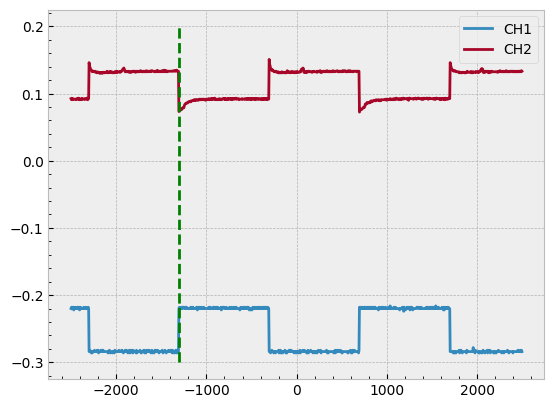

In [26]:
plt.plot(t_1, V_1, label = "CH1")
plt.plot(t_2, V_2, label = "CH2")
plt.vlines(-1305, ymin = -0.3, ymax = 0.2, ls = "--", color = "g")
# plt.xlim(-1320,-1300)
plt.legend()
plt.show()

## Reescaleando las señales

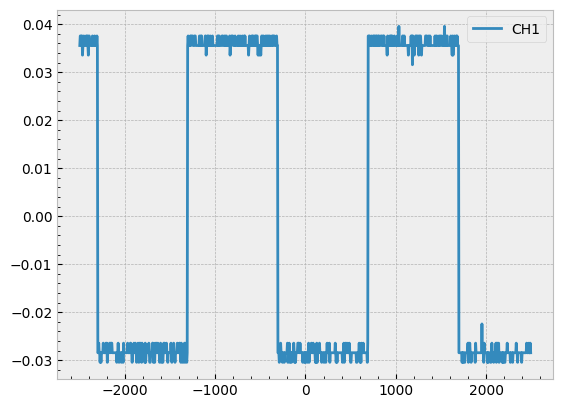

In [27]:
plt.plot(t_1, V_1-np.mean(V_1), label = "CH1")
plt.legend()
plt.show()

In [28]:
V_1_shifted = V_1-np.mean(V_1)
V_1_max = np.mean(V_1_shifted[V_1_shifted > 0])
V_1_min  = np.mean(V_1_shifted[V_1_shifted < 0])

V_1_amp = (V_1_max-V_1_min)/2
print(V_1_amp)

0.032272940422442095


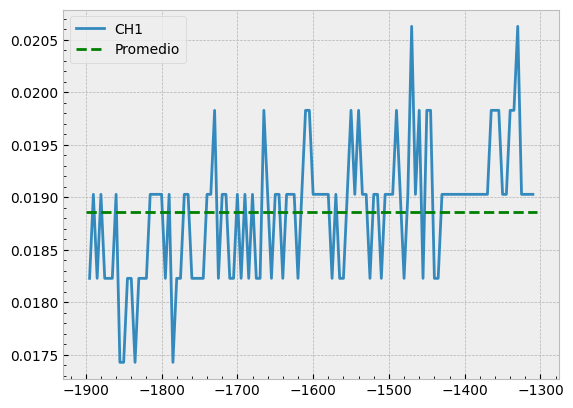

In [29]:
# Hallando el máximo
plt.plot(t_2[(-1305 > t_2) & (t_2 > -1900)], (V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)], label = "CH1")
plt.hlines(np.mean((V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)]),xmin = -1900, xmax = -1305, ls = "--", color = "g", label = "Promedio")
plt.legend()
plt.show()

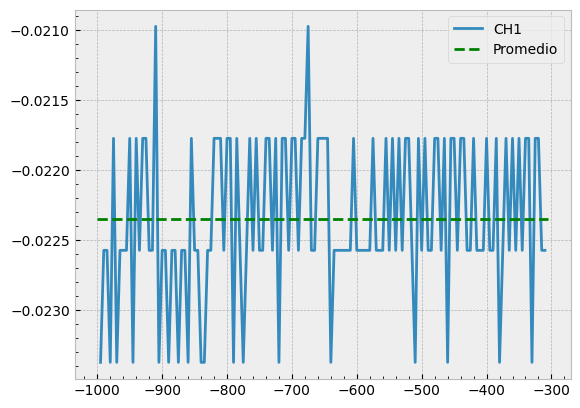

In [30]:
# Hallando el mínimo
t_max = -305
t_min = -1000
plt.plot(t_2[(t_max > t_2) & (t_2 > t_min)], (V_2-np.mean(V_2))[(t_max > t_2) & (t_2 > t_min)], label = "CH1")
plt.hlines(np.mean((V_2-np.mean(V_2))[(t_max > t_2) & (t_2 > t_min)]),xmin = t_min, xmax = t_max, ls = "--", color = "g", label = "Promedio")
plt.legend()
plt.show()

In [31]:
V_2_max = np.mean((V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)])
V_2_min  = np.mean((V_2-np.mean(V_2))[(-305 > t_2) & (t_2 > -1000)])

V_2_amp = (V_2_max-V_2_min)/2
print(V_2_amp)

0.020602210759027267


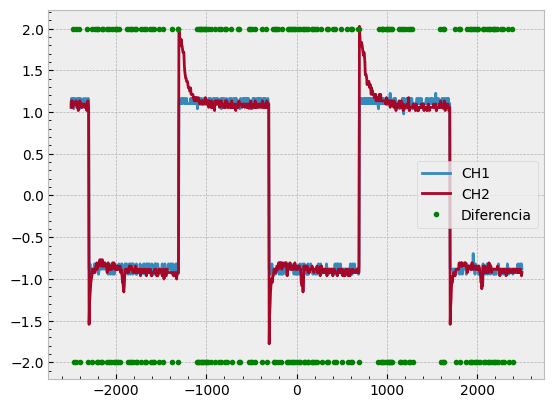

In [32]:
V_1_reescaled = (V_1-np.mean(V_1))/V_1_amp
V_2_reescaled = -(V_2-np.mean(V_2))/V_2_amp

channel_diff = np.diff(np.sign(V_2_reescaled - V_1_reescaled))
index = np.argwhere(channel_diff).flatten()

plt.plot(t_1, V_1_reescaled, label = "CH1")
plt.plot(t_2, V_2_reescaled, label = "CH2")
plt.plot(t_1[index], channel_diff[index],".", color = "g", label = "Diferencia")
plt.legend()
plt.show()

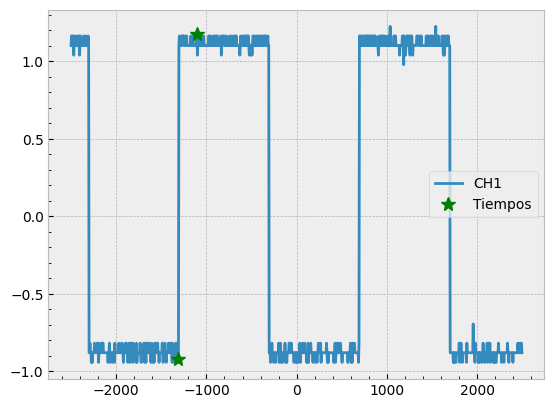

In [33]:
ind_r = index[(t_2[index] > -1200)][0]
ind_s = index[(t_2[index] < -1200)][-1]

plt.plot(t_1, V_1_reescaled, label = "CH1")
# plt.plot(t_2[index], V_2_reescaled[index], label = "CH2", marker = ".", ls = "")
# plt.plot(t_1[index], channel_diff[index],".", color = "g", label = "Diferencia")
# plt.plot(t_1[index][:-1][(V_2_reescaled[index][1:] > 0) & (V_2_reescaled[index][:-1] < 0)], V_2_reescaled[index][:-1][(V_2_reescaled[index][1:] > 0) & (V_2_reescaled[index][:-1] < 0)], color = "g")
plt.plot(t_2[np.array([ind_r,ind_s])], V_2_reescaled[np.array([ind_r,ind_s])], c='g', label='Tiempos', marker = "*", ls = "", ms = 10)
plt.legend()
plt.show()

In [34]:
abs(np.diff(t_2[np.array([ind_r,ind_s])]))[0]*1e-3

0.2

In [35]:
t_r = t_2[index][(t_2[index] > -1200)][0]
t_s = t_2[index][(t_2[index] < -1200)][-1]

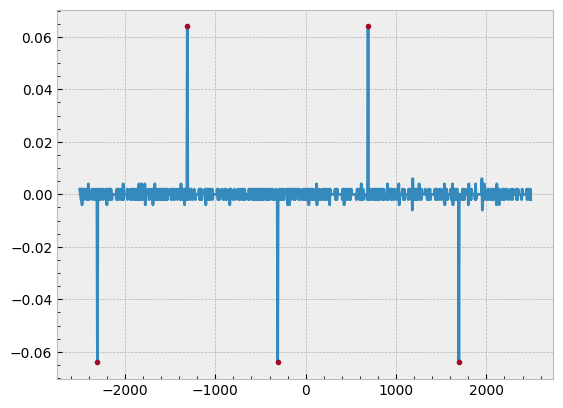

In [36]:
plt.plot(t_1[:-1],np.diff(V_1))
plt.plot(t_1[:-1][np.abs(np.diff(V_1)) > 0.01],np.diff(V_1)[np.abs(np.diff(V_1)) > 0.01],".")
plt.show()

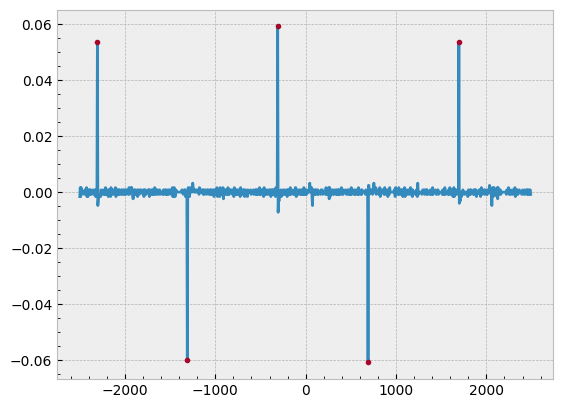

In [37]:
plt.plot(t_2[:-1],np.diff(V_2))
plt.plot(t_2[:-1][np.abs(np.diff(V_2)) > 0.01],np.diff(V_2)[np.abs(np.diff(V_2)) > 0.01],".")
plt.show()

# 2do método - Calculando el ancho de banda de la transformada de Fourier de la señal


## Automatizado

In [53]:
amps, offsets = [1,0.5], [1, 2]
tiempos = ["10 us", "1 ms", "10 ms", "100 ms"]

t_rta_dict = {}
for amp, offset in zip(amps, offsets):
    for tiempo in tiempos:
        file_name = f"../mediciones/D.D/Tiempo de respuesta del laser/T_rta 2 kHz {amp} Amp {offset} OFFS {tiempo}.pickle "
        # Cargamos los datos
        with open(file_name, "rb") as f:
            dic = pickle.load(f)

        t_1, V_1, t_2, V_2 = [dic[f"{offset}V"][key] for key in dic[f"{offset}V"].keys()]
        t_1, t_2 = t_1/1000, t_2/1000 # Porque están en milisegundos

        frec_1_peaks, tf_1_peaks = calculate_fourier_freqs(t_1, V_1)
        frec_2_peaks, tf_2_peaks = calculate_fourier_freqs(t_2, V_2)

        t_rta = 1/frec_2_peaks[-1]*1000
        t_rta_dict[f"{amp} amp {offset} OFFS {tiempo}"] = t_rta

print("T_rta en ms \n",t_rta_dict.values())

T_rta en ms 
 dict_values([0.0004123711340206185, 0.04024144869215292, 0.4040404040404041, 4.065040650406504, 0.0004123711340206185, 0.04056795131845842, 0.4040404040404041, 4.065040650406504])


## Para una medición en particular

In [57]:
amp = 1
offset = 1
tiempo = "10 us"
file_name = f"../mediciones/D.D/Tiempo de respuesta del laser/T_rta 2 kHz {amp} Amp {offset} OFFS {tiempo}.pickle "
# Cargamos los datos
with open(file_name, "rb") as f:
    dic = pickle.load(f)

In [58]:
t_1, V_1, t_2, V_2 = [dic[f"{offset}V"][key] for key in dic[f"{offset}V"].keys()]
t_1, t_2 = t_1/1000, t_2/1000 # Porque están en milisegundos

### Visualizando las mediciones

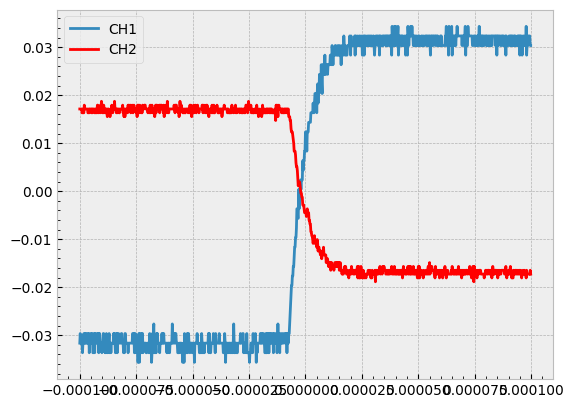

In [56]:
no_off_V_1 = V_1 - np.mean(V_1)
no_off_V_2 = V_2 - np.mean(V_2)

plt.plot(t_1, no_off_V_1, label = "CH1")
plt.plot(t_2, no_off_V_2, label = "CH2", color = "r")
plt.legend()
plt.show()

### Transformamos en Fourier

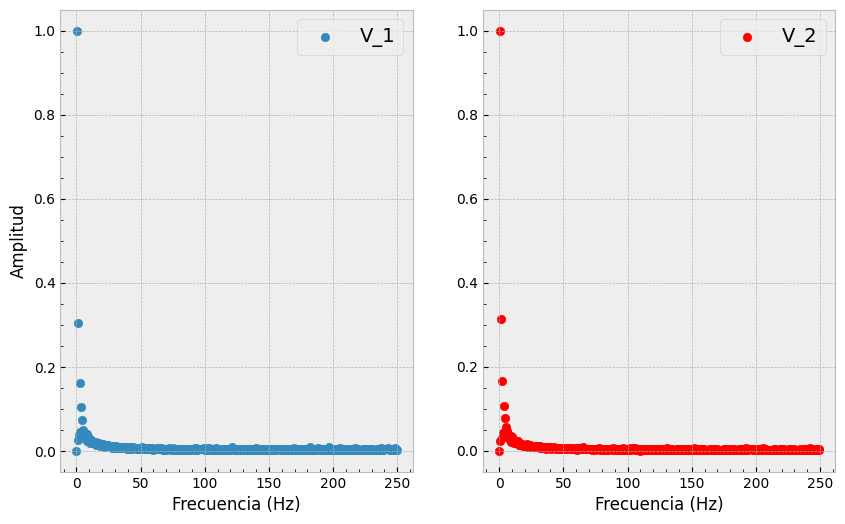

In [49]:
frec_1, tf_1 = fourier_transform(t_1,no_off_V_1)
tf_1 = tf_1/max(tf_1)

frec_2, tf_2 = fourier_transform(t_2,no_off_V_2)
tf_2 = tf_2/max(tf_2)

fig,axs = plt.subplots(ncols = 2, figsize = (10,6))


axs[0].scatter(frec_1, tf_1, label='V_1')
axs[1].scatter(frec_2, tf_2, label='V_2', color = "r")

axs[0].set_xlabel('Frecuencia (Hz)')
axs[1].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Amplitud')
axs[0].legend(fontsize = 14)
axs[1].legend(fontsize = 14)
plt.show()

Calculamos los picos

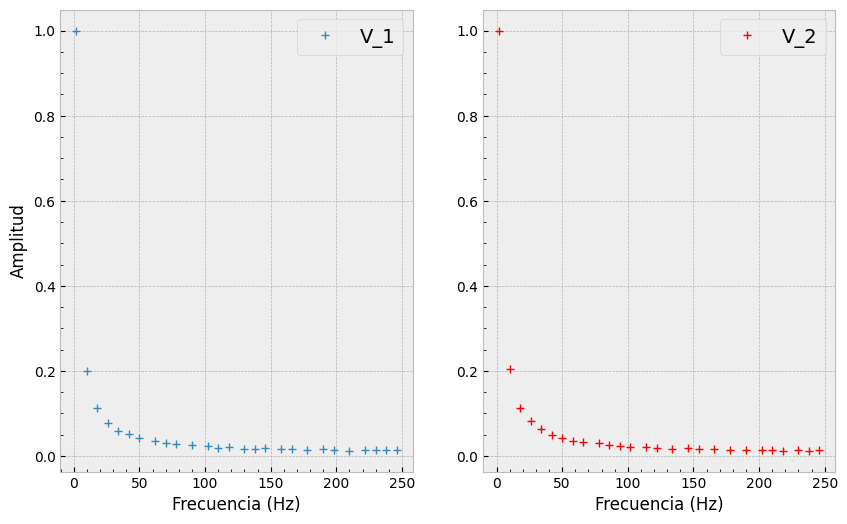

In [50]:
frec_1_peaks, tf_1_peaks = calculate_fourier_freqs(t_1, V_1)
frec_2_peaks, tf_2_peaks = calculate_fourier_freqs(t_2, V_2)


fig,axs = plt.subplots(ncols = 2, figsize = (10,6))

axs[0].plot(frec_1_peaks,tf_1_peaks,"+", label = "V_1")
axs[1].plot(frec_2_peaks,tf_2_peaks,"+", label = "V_2", color = "r")
#axs[0].set_xscale("log")
#axs[1].set_xscale("log")
axs[0].set_xlabel("Frecuencia (Hz)")
axs[1].set_xlabel("Frecuencia (Hz)")
axs[0].set_ylabel("Amplitud")
axs[0].legend(fontsize = 14)
axs[1].legend(fontsize = 14)
plt.show()

In [51]:
print(frec_2_peaks)

[  2.  10.  18.  26.  34.  42.  50.  58.  66.  78.  86.  94. 102. 114.
 122. 134. 146. 154. 166. 178. 190. 202. 210. 218. 230. 238. 246.]


In [52]:
print(f"El tiempo de respuesta es de {1/frec_2_peaks[-1]*1000} ms")

El tiempo de respuesta es de 4.065040650406504 ms
